<a href="https://colab.research.google.com/github/Ibrahimsyah/Foories/blob/master/notebooks/03_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown -q

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [4]:
!gdown 'https://drive.google.com/uc?id=1m2WYGHvONlBjAUfbmPtU1BYAdm1PaDSe' -O dataset_cleaned.zip

Downloading...
From: https://drive.google.com/uc?id=1m2WYGHvONlBjAUfbmPtU1BYAdm1PaDSe
To: /content/dataset_cleaned.zip
173MB [00:01, 104MB/s]


In [5]:
!mkdir dataset
!unzip -q dataset_cleaned.zip

In [6]:
train_dir = "/content/content/dataset/train"
valid_dir = "/content/content/dataset/dev"
test_dir = "/content/content/dataset/test"

In [17]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299) and output dimension 2048


In [18]:
BATCH_SIZE = 64 #@param {type:"integer"}

In [19]:
do_fine_tuning = False #@param {type:"boolean"}

In [20]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [21]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(16, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32784     
Total params: 21,835,568
Trainable params: 32,784
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [23]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [24]:
# Training datagen
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 11372 images belonging to 16 classes.
Found 2150 images belonging to 16 classes.


##Inception_v3

In [25]:
EPOCHS = 10

hist1 = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator)

Epoch 1/10
178/178 [==============================] - 133s 714ms/step - loss: 1.6444 - accuracy: 0.5055 - val_loss: 0.8841 - val_accuracy: 0.7121
Epoch 2/10
178/178 [==============================] - 124s 695ms/step - loss: 0.8552 - accuracy: 0.7300 - val_loss: 0.8500 - val_accuracy: 0.7102
Epoch 3/10
178/178 [==============================] - 123s 693ms/step - loss: 0.7996 - accuracy: 0.7416 - val_loss: 0.7962 - val_accuracy: 0.7419
Epoch 4/10
178/178 [==============================] - 123s 693ms/step - loss: 0.7127 - accuracy: 0.7639 - val_loss: 0.8325 - val_accuracy: 0.7195
Epoch 5/10
178/178 [==============================] - 123s 690ms/step - loss: 0.6858 - accuracy: 0.7812 - val_loss: 0.7627 - val_accuracy: 0.7488
Epoch 6/10
178/178 [==============================] - 123s 691ms/step - loss: 0.6324 - accuracy: 0.7946 - val_loss: 0.7556 - val_accuracy: 0.7498
Epoch 7/10
178/178 [==============================] - 123s 690ms/step - loss: 0.6202 - accuracy: 0.7955 - val_loss: 0.7804 -

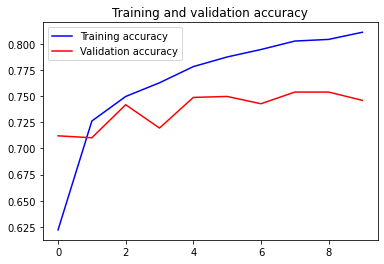

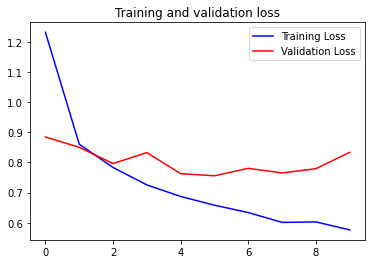

In [26]:
import matplotlib.pyplot as plt
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##MobileNet_v2

In [15]:
EPOCHS = 10

hist2 = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator)

Epoch 1/10
178/178 [==============================] - 156s 683ms/step - loss: 1.7206 - accuracy: 0.4818 - val_loss: 0.8441 - val_accuracy: 0.7335
Epoch 2/10
178/178 [==============================] - 120s 673ms/step - loss: 0.7955 - accuracy: 0.7634 - val_loss: 0.7254 - val_accuracy: 0.7707
Epoch 3/10
178/178 [==============================] - 119s 667ms/step - loss: 0.6848 - accuracy: 0.7859 - val_loss: 0.6895 - val_accuracy: 0.7791
Epoch 4/10
178/178 [==============================] - 119s 669ms/step - loss: 0.6278 - accuracy: 0.8043 - val_loss: 0.6896 - val_accuracy: 0.7907
Epoch 5/10
178/178 [==============================] - 118s 667ms/step - loss: 0.5856 - accuracy: 0.8180 - val_loss: 0.6635 - val_accuracy: 0.7926
Epoch 6/10
178/178 [==============================] - 118s 665ms/step - loss: 0.5628 - accuracy: 0.8232 - val_loss: 0.6582 - val_accuracy: 0.7940
Epoch 7/10
178/178 [==============================] - 119s 668ms/step - loss: 0.5256 - accuracy: 0.8354 - val_loss: 0.6453 -

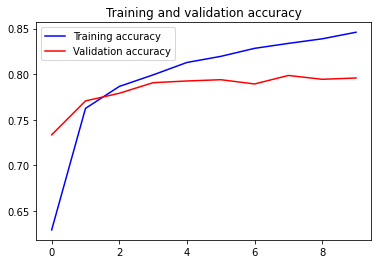

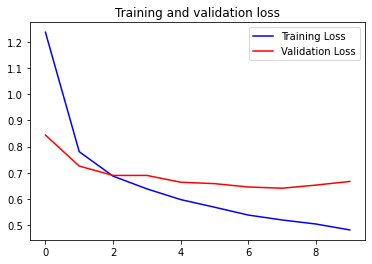

In [16]:
import matplotlib.pyplot as plt
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()